**Opinion dynamics.**


$$
  \frac{d}{dt}\mathbf{x}_{i} = \alpha \sum_{j \neq i}a_{ij}(\mathbf{x}_{j}-\mathbf{x}_{i}), ~~ a_{ij}=\frac{\phi_{ij}}{\sum_{k}\phi_{ik}}, ~~ \phi_{ij}:=\phi(|\mathbf{x}_{j}-\mathbf{x}_{i}|).
$$

其中$\phi=1\chi_{[0,1]}$

### 原始代码  
BsplineKANLayer

In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from deepkan import SplineLinearLayer
from KAN import KANModel
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn


torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数
# 超参数
n_steps = 10000            # 样本取点数               
steps = 5001             # 迭代次数
log = 1                  # 迭代序号
M = 1                    # 多步法的步数
y0 = np.random.uniform(0, 10, 50)     # 方程初始值
# y0 = np.array([5.55556439, 6.1202558 , 1.31589088, 4.17806003, 7.34753466,
#        7.12816785, 9.06880371, 1.29676763, 3.42225157, 5.43237047,
#        0.11059067, 7.80974994, 6.03670891, 0.81373324, 3.246417  ,
#        4.60066361, 1.68067959, 3.98806168, 7.98200535, 0.50534268,
#        1.50309975, 4.42313428, 1.44786952, 3.1469025 , 2.39320796,
#        6.69964605, 7.46626908, 4.08491387, 4.63274641, 4.58568309,
#        8.95743239, 3.0584266 , 5.00243975, 8.70777599, 2.27919911,
#        1.04429653, 2.06838483, 3.14724888, 8.61008361, 4.92128717,
#        9.977988  , 8.81160548, 8.56214329, 2.34193884, 2.56452312,
#        9.95976192, 9.18023511, 8.96248071, 2.0985968 , 2.22661127]) 
t_np = np.linspace(0, 10, num=n_steps)
dt = t_np[M] - t_np[0]   # 步长


def phi(r):
    if 0 <= r <= 1:
        return 1
    else:
        return 0
    
def f(x, t, alpha=1, N=50):
            # 假设 x 是一维数组，包含 N 个标量 x_i
            f = np.zeros(N)  # 初始化 dx/dt，形状为 (N,)
            
            for i in range(N):
                phi_ik_sum = sum(phi(abs(x[k] - x[i]))  for k in range(N) if k != i)
                for j in range(N):
                    if i != j:
                        # 计算 x_j - x_i
                        diff = x[j] - x[i]
                        phi_ij = phi(abs(diff))
                        # 计算 a_ij = phi_ij / sum(phi_ik)
                        if phi_ik_sum != 0:
                            a_ij = phi_ij / phi_ik_sum
                        else:
                            a_ij = 0  # 如果分母为 0，则 a_ij 为 0
                        # 累加 alpha * a_ij * (x_j - x_i) 到 f[i]
                        f[i] += alpha * a_ij * diff
            
            return f.flatten()  # 返回一维数组

# 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
y_np = odeint(f, y0, t_np) 
y_train = y_np[0::M,:]
y_train_new  = torch.tensor(y_train)


lamb = 0.1
model = KANModel(width=[50,101,50], grid_range=[0,10])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,betas=(0.9, 0.999), eps=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y


# 用于存储每次迭代的损失值
Train_loss_list = []
iteration_list = []
times = []
target_loss = 1e-14

start_time = time.time()
for epoch in range(steps):
    model.train()
    scheme = 'AM'
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)

    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = torch.mean((Y_pred)**2)
    l2loss = criterion(Y_pred, torch.zeros_like(Y_pred)) + lamb * model.reg(y_train_new)
    l2loss.backward()
    optimizer.step()
    current_time = time.time()
    iteration_time = current_time - start_time

    # 存储损失值和迭代次数
    times.append(iteration_time)
    Train_loss_list.append(loss.cpu().detach().numpy())
    iteration_list.append(epoch)


    if epoch % 500 == 0:
        # print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e}, Time per iteration: {iteration_time:.4f} seconds')
        # print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e},  Test_loss: {Test_loss.item(): .16e}')
        print(f'Epoch {epoch+1}/{steps}, loss: {loss.item(): .16e}')
    
    if loss.item() < target_loss:
            print(f'Target loss reached at iteration {epoch+1}.')
            break


Epoch 1/5001, loss:  4.2984610712568577e-05
Epoch 501/5001, loss:  5.1007546695097273e-09
Epoch 1001/5001, loss:  2.9072056328559570e-09
Epoch 1501/5001, loss:  2.1270027837150309e-09
Epoch 2001/5001, loss:  1.9546108459709223e-09
Epoch 2501/5001, loss:  1.5779726854044162e-09
Epoch 3001/5001, loss:  1.6302016040279449e-09
Epoch 3501/5001, loss:  1.3562208508353471e-09
Epoch 4001/5001, loss:  1.1390168654639609e-09
Epoch 4501/5001, loss:  1.1629328693672041e-09
Epoch 5001/5001, loss:  8.8556859404597230e-10


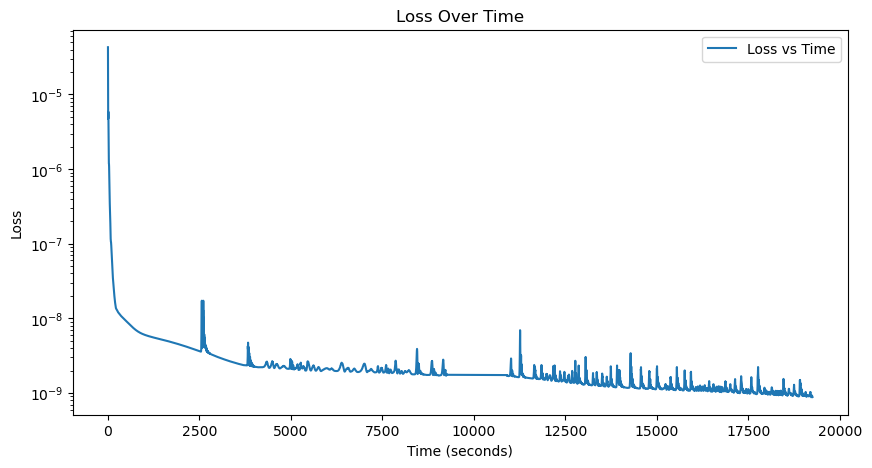

In [2]:
# 绘制时间和误差的关系图
plt.figure(figsize=(10, 5))
plt.plot(times, Train_loss_list, label='Loss vs Time')
plt.yscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [3]:
# # 储存数据
# import csv
# csv_file = 'loss_time_data.csv'
# with open(csv_file, 'w', newline='') as file:
#     writer = csv.writer(file)
#     # writer.writerow(['Epoch', 'Loss1'])
#     for iteration_list_val, loss_val in zip(iteration_list, Train_loss_list):
#         writer.writerow([iteration_list_val, loss_val])

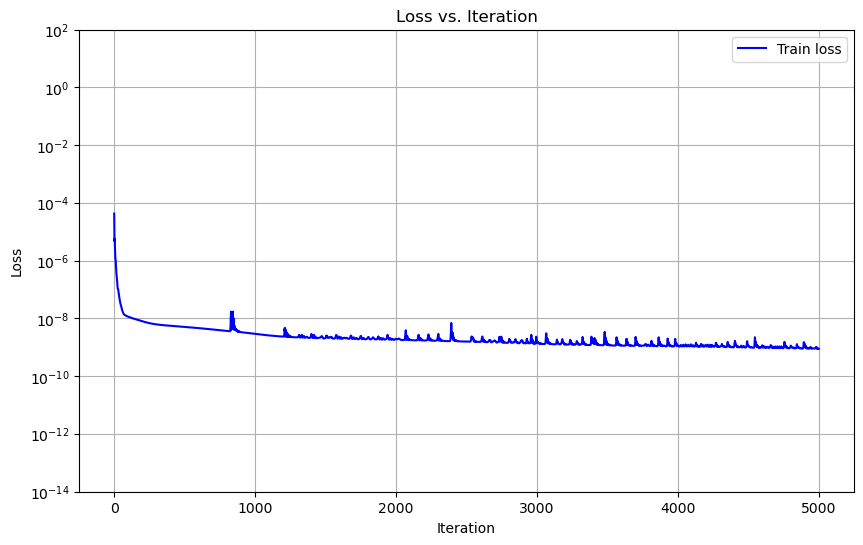

In [4]:
# 绘制迭代次数和误差的关系图
plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label='Train loss', color='b')
plt.yscale('log')
plt.ylim(10e-15, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
# plt.show()
# plt.savefig('Cubic2D_Error_10-6.png', format='png', dpi=600)

In [5]:
test_steps = n_steps
test_np = np.linspace(0, 15, test_steps)
test_np_new = torch.linspace(0, 15, test_steps)
# t_span = (0, 2)



def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()


def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()

learned_X_star = odeint(learned_f, y0, test_np)     
y_np1 = odeint(f, y0, test_np) 



# loss = np.mean((learned_X_star-y_np)**2)
Mean_loss = np.mean((learned_X_star-y_np)**2)  
l2_loss = np.sqrt(np.sum((learned_X_star-y_np)**2))
linf_loss = np.max(np.abs(learned_X_star-y_np))
print(f'Mean_loss: {Mean_loss.item(): .8e}, l2_loss: {l2_loss.item(): .8e}, linf_loss: {linf_loss.item(): .8e}')
# lossx1 = np.max(learned_X_star[:,0]-y_np[:,0])
# lossx2 = np.max(learned_X_star[:,1]-y_np[:,1])
# print('x1_loss: {lossx1: .16e}, x2_loss: {lossx2: .16e}'.format(lossx1=lossx1, lossx2=lossx2))

Mean_loss:  1.32932601e-02, l2_loss:  8.15268671e+01, linf_loss:  7.72828660e-01


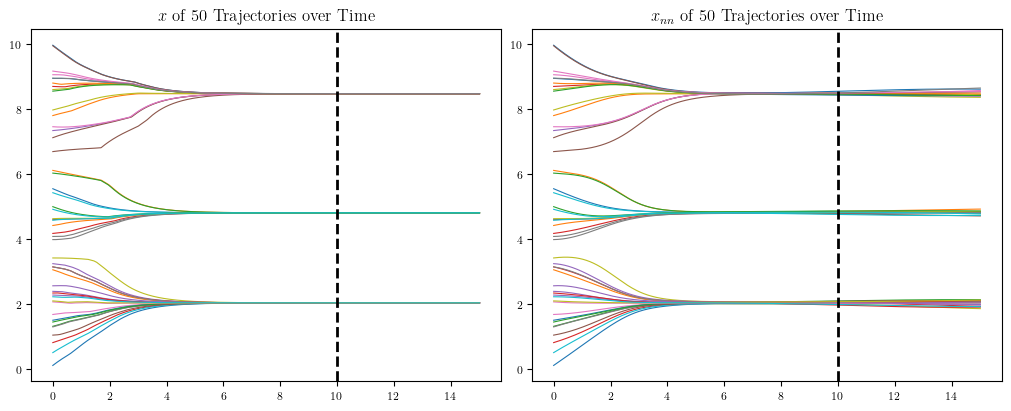

In [6]:
from plotting import newfig, savefig
import matplotlib.pyplot as plt
# 创建图形


fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')

# 绘制每一条解
for i in range(50):
    axs[0].plot(test_np, y_np1[:, i], linewidth=0.8)
    
axs[0].set_title('$x$ of $50$ Trajectories over Time') 
axs[0].axvline(x=10, color='k', linestyle='--', linewidth=2)

for i in range(50):
    axs[1].plot(test_np, learned_X_star[:, i], linewidth=0.8)
    
axs[1].set_title('$x_{nn}$ of $50$ Trajectories over Time')
axs[1].axvline(x=10, color='k', linestyle='--', linewidth=2)
# for i in range(50):
#     plt.plot(t_star, X_star[:, i], label=f'Solution {i+1}', linewidth=0.8)

# 图形的标题和标签

# plt.xlabel("Time")
# plt.ylabel("x values")
# plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0), fontsize='small', ncol=1, frameon=False)
# plt.savefig('50KAN_Self_organized_3_10_10000_5001_0.001_15.png', format='png', dpi=600)